In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
dest = '/content/drive/MyDrive/HSE Final Project/to_train'
name = 'submit_9_abandoned.csv'

df = pd.read_csv(dest + '/' + name)
df.head()

,shop_id,item_id,month,year,date_block_num,item_cnt,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt
0,0,19,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02222,0.0,0.02222
1,0,27,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,19,False,5,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15550,0.0,0.05682
2,0,28,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,30,False,5,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17770,0.0,0.14120
3,0,29,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,23,False,5,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08887,0.0,0.03738
4,0,32,1,2013,0,6,221.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.64500,8.0,1.31900


In [3]:
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['month'] = df['month'].astype(np.int8)
df['year'] = df['year'].astype(np.int16)
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['item_cnt'] = df['item_cnt'].astype(np.int32)
df['prev_value'] = df['prev_value'].astype(np.int32)
df['prev_value_year'] = df['prev_value_year'].astype(np.int32)
df['shop_city'] = df['shop_city'].astype(np.int8)
df['shop_category'] = df['shop_category'].astype(np.int8)
df['item_category_id'] = df['item_category_id'].astype(np.int8)
df['digital'] = df['digital'].astype(np.bool_)
df['category_type'] = df['category_type'].astype(np.int8)
df['category_subtype'] = df['category_subtype'].astype(np.int8)
df['item_cnt_lag_2'] = df['item_cnt_lag_2'].astype(np.int32)
df['item_cnt_lag_3'] = df['item_cnt_lag_3'].astype(np.int32)
df['item_cnt_lag_4'] = df['item_cnt_lag_4'].astype(np.int32)
df['item_cnt_lag_5'] = df['item_cnt_lag_5'].astype(np.int32)
df['item_cnt_lag_6'] = df['item_cnt_lag_6'].astype(np.int32)

In [4]:
for col in df.columns[22:40]:
    df[col] = df[col].astype(np.int32)

In [5]:
df.shape

(10913804, 43)

In [6]:
df = df[df.date_block_num >= 12] 

In [7]:
df.reset_index(drop=True, inplace=True)
df.shape

(6425094, 43)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 43 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   shop_id                    int8   
 1   item_id                    int16  
 2   month                      int8   
 3   year                       int16  
 4   date_block_num             int8   
 5   item_cnt                   int32  
 6   item_price                 float64
 7   prev_value                 int32  
 8   prev_value_year            int32  
 9   stock_prev                 float64
 10  stock_prev_year            float64
 11  shop_city                  int8   
 12  shop_category              int8   
 13  item_category_id           int8   
 14  digital                    bool   
 15  category_type              int8   
 16  category_subtype           int8   
 17  item_cnt_lag_2             int32  
 18  item_cnt_lag_3             int32  
 19  item_cnt_lag_4             int32  
 20  it

Due to the fact that we predict future, it makes no sense to shuffle the data

In [9]:
# Indices for RandomizedSearchCV
index = df.index

condition_train = df.date_block_num < 33
train_indices = index[condition_train]

condition_valid = df.date_block_num == 33
valid_indices = index[condition_valid]

train_indices = train_indices.tolist()
valid_indices = valid_indices.tolist()

print(train_indices[-5:])
print(valid_indices[-5:])

[6186917, 6186918, 6186919, 6186920, 6186921]
[6425089, 6425090, 6425091, 6425092, 6425093]


In [10]:
X = df.drop(['item_cnt'], axis=1)
y = df['item_cnt']

In [11]:
del df

GridSearchCV

**Good Params:**

*   Max_depth: 7 < x <= 9 (the biggest 10)
*   Min_child_weight: x = 5
*   col_sample_by_tree: 0.7 <= x <= 0.9
*   eta: x >= 0.05
*   n_estimators < 1000


---


The best model yet:
colsample_bytree=0.9, learning_rate=0.05, max_depth=9, min_child_weight=5, n_estimators=300;, score=-4.012



P.S. After a lot of time-consuming trainings these params were chosen.

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# custom_cv = [(train_indices, valid_indices)]
params = {'learning_rate': [0.05, 0.1, 0.3, 0.5, 1], 
          'subsample': [0.6, 0.7, 0.8, 0.9, 1],
          'max_depth': [7, 8, 9, 10],
          'min_child_weight': [5, 10],
          'colsample_bytree': [0.8, 0.9],
          'n_estimators': [300, 500, 1000],
          'gamma': [0, 0.5, 1, 1.5, 2, 5]}

fit_params={"early_stopping_rounds": 12,
            "eval_metric": "rmse", 
            "eval_set": [(X.loc[valid_indices], y.loc[valid_indices])],
            "verbose": 2}

In [13]:
splits = []
for block in [29, 30, 31, 32, 33]:
    train_idxs = X[X.date_block_num < block].index.values
    test_idxs = X[X.date_block_num == block].index.values
    splits.append((train_idxs, test_idxs))

In [14]:
splits

[(array([      0,       1,       2, ..., 5300551, 5300552, 5300553]),
  array([5300554, 5300555, 5300556, ..., 5524839, 5524840, 5524841])),
 (array([      0,       1,       2, ..., 5524839, 5524840, 5524841]),
  array([5524842, 5524843, 5524844, ..., 5753728, 5753729, 5753730])),
 (array([      0,       1,       2, ..., 5753728, 5753729, 5753730]),
  array([5753731, 5753732, 5753733, ..., 5968264, 5968265, 5968266])),
 (array([      0,       1,       2, ..., 5968264, 5968265, 5968266]),
  array([5968267, 5968268, 5968269, ..., 6186919, 6186920, 6186921])),
 (array([      0,       1,       2, ..., 6186919, 6186920, 6186921]),
  array([6186922, 6186923, 6186924, ..., 6425091, 6425092, 6425093]))]

In [15]:
random_state = 13
verbosity = 2
gp = 'gpu_hist'
obj = 'reg:squarederror'

In [16]:
xgbr = xgb.XGBRegressor(verbosity=verbosity,
                        objective=obj,
                        tree_method = gp,
                        random_state=random_state)

In [17]:
# X_train = df[df.date_block_num < 33].drop(['item_cnt'], axis=1)
# y_train = df[df.date_block_num < 33]['item_cnt']
# X_valid = df[df.date_block_num == 33].drop(['item_cnt'], axis=1)
# y_valid = df[df.date_block_num == 33]['item_cnt']

In [18]:
# xgbr.fit(X_train, y_train,
#          eval_metric=['rmse', 'rmse'], eval_set=eval_set,
#          early_stopping_rounds=15, verbose=True)

In [19]:
grid_obj_xgbr = RandomizedSearchCV(xgbr, params,
                                   cv=splits,
                                   n_iter=50,
                                   scoring='neg_root_mean_squared_error',
                                   verbose=3)

In [20]:
grid_obj_xgbr.fit(X, y, **fit_params)

Выходные данные были обрезаны до нескольких последних строк (5000).
[24]	validation_0-rmse:4.36599
[26]	validation_0-rmse:4.3597
[28]	validation_0-rmse:4.35969
[30]	validation_0-rmse:4.37026
[32]	validation_0-rmse:4.365
[34]	validation_0-rmse:4.35283
[36]	validation_0-rmse:4.3695
[38]	validation_0-rmse:4.37704
[40]	validation_0-rmse:4.38145
[42]	validation_0-rmse:4.37818
[44]	validation_0-rmse:4.37918
[46]	validation_0-rmse:4.38355
Stopping. Best iteration:
[34]	validation_0-rmse:4.35283

[CV 3/5] END colsample_bytree=0.9, gamma=2, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=1000, subsample=0.8;, score=-0.965 total time=  19.9s
[0]	validation_0-rmse:4.89719
Will train until validation_0-rmse hasn't improved in 12 rounds.
[2]	validation_0-rmse:4.45553
[4]	validation_0-rmse:4.31469
[6]	validation_0-rmse:4.27598
[8]	validation_0-rmse:4.19499
[10]	validation_0-rmse:4.20791
[12]	validation_0-rmse:4.16741
[14]	validation_0-rmse:4.17034
[16]	validation_0-rmse:4.16566
[18]

RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 5300551, 5300552, 5300553]),
                        array([5300554, 5300555, 5300556, ..., 5524839, 5524840, 5524841])),
                       (array([      0,       1,       2, ..., 5524839, 5524840, 5524841]),
                        array([5524842, 5524843, 5524844, ..., 5753728, 5753729, 5753730])),
                       (array([      0,       1,       2, ..., 5753728, 5753729, 5753730]),
                        array([5753731, 5753732, 5753733, ..., 5968264, 5968265, 5968266])),
                       (array([      0...
                   estimator=XGBRegressor(objective='reg:squarederror',
                                          random_state=13,
                                          tree_method='gpu_hist', verbosity=2),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.8, 0.9],
                                        'gamma': [0, 0.5, 1, 1.5, 2, 5],
                 

In [21]:
print("\n The best estimator across ALL searched params:\n", grid_obj_xgbr.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_obj_xgbr.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_obj_xgbr.best_params_)


 The best estimator across ALL searched params:
 XGBRegressor(colsample_bytree=0.9, gamma=2, learning_rate=0.5, max_depth=8,
             min_child_weight=5, n_estimators=500, objective='reg:squarederror',
             random_state=13, subsample=0.9, tree_method='gpu_hist',
             verbosity=2)

 The best score across ALL searched params:
 -2.3636728504578244

 The best parameters across ALL searched params:
 {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 2, 'colsample_bytree': 0.9}


In [22]:
xgbr = grid_obj_xgbr.best_estimator_

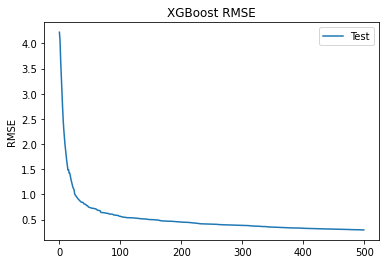

In [23]:
import matplotlib.pyplot as plt

# retrieve performance metrics
results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Test')
# ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [24]:
import pickle

dest = '/content/drive/MyDrive/HSE Final Project/Models/'
file_name = 'xgb_reg_7.pkl'

# save
pickle.dump(xgbr, open(dest + file_name, 'wb'))

In [25]:
import pickle

dest = '/content/drive/MyDrive/HSE Final Project/Models/'
file_name = 'xgb_reg_7.pkl'
# load
xgbr = pickle.load(open(dest + file_name, "rb"))

[18:22:52] INFO: /workspace/src/learner.cc:370: Parameter 'predictor' has been recovered from the saved model. It will be set to 'gpu_predictor' for prediction. To override the predictor behavior, explicitly set 'predictor' parameter as follows:
  * Python package: bst.set_param('predictor', [new value])
  * R package:      xgb.parameters(bst) <- list(predictor = [new value])
  * JVM packages:   bst.setParam("predictor", [new value])


In [26]:
from sklearn.metrics import mean_squared_error

X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]
y_pred = xgbr.predict(X_valid)
y_pred_rounded = np.around(y_pred)
mse = mean_squared_error(y_valid, y_pred)
mse_rd = mean_squared_error(y_valid, y_pred_rounded)

print('MSE: %.2f' % mse)
print('RMSE: %.2f' % (mse ** (0.5)))

print('MSE (rounded): %.2f' % mse_rd)
print('RMSE (rounded): %.2f' % (mse_rd ** (0.5)))

MSE: 0.09
RMSE: 0.30
MSE (rounded): 0.09
RMSE (rounded): 0.31


In [27]:
# from sklearn.metrics import mean_squared_log_error
# msle = mean_squared_log_error(y_test, y_pred)
# print('RMSLE: %.2f' % (msle ** (0.5)))

In [28]:
dest = '/content/drive/MyDrive/HSE Final Project/to_test'
name = 'submit_9_test.csv'

test_df = pd.read_csv(dest + '/' + name)
test_df.head()

,shop_id,item_id,month,year,date_block_num,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt
0,5,5037,11,2015,34,2599.0,0,1,0.0,2599.0,3,3,19,False,5,9,1,3,1,1,1,1052,1092,1294,991,954,1445,25,110,119,54,105,65,21346,24604,23616,19872,22261,49726,0.0,0.9287,1.951
1,5,5320,11,2015,34,0.0,0,0,0.0,0.0,3,3,55,False,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000
2,5,5233,11,2015,34,1199.0,1,0,1199.0,0.0,3,3,19,False,5,9,3,1,0,2,3,1052,1092,1294,991,954,0,42,80,150,37,119,0,21346,24604,23616,19872,22261,0,0.0,1.4290,1.657
3,5,5232,11,2015,34,599.0,0,0,0.0,0.0,3,3,23,False,5,18,0,1,0,0,0,1052,1092,1294,0,0,0,28,48,65,0,0,0,21346,24604,23616,0,0,0,0.0,0.3333,1.093
4,5,5268,11,2015,34,0.0,0,0,0.0,0.0,3,3,20,False,5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000


In [29]:
test_pred = xgbr.predict(test_df)
print(test_pred)

[-2.6114792e-01 -1.4683604e-03 -1.1679718e+00 ...  7.5884372e-01
 -5.5778027e-04  1.5248686e-01]


In [30]:
name_sample = 'sample_submission.csv'

sample = pd.read_csv(dest + '/' + name_sample)
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [31]:
sample.item_cnt_month = np.around(test_pred)
sample.head()

,ID,item_cnt_month
0,0,-0.0
1,1,-0.0
2,2,-1.0
3,3,0.0
4,4,-0.0


In [32]:
dest = '/content/drive/MyDrive/HSE Final Project/submissions/'
sample.to_csv(dest + 'submission #19.csv', index=False)

In [33]:
from xgboost import plot_importance
import matplotlib.pyplot as plt


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

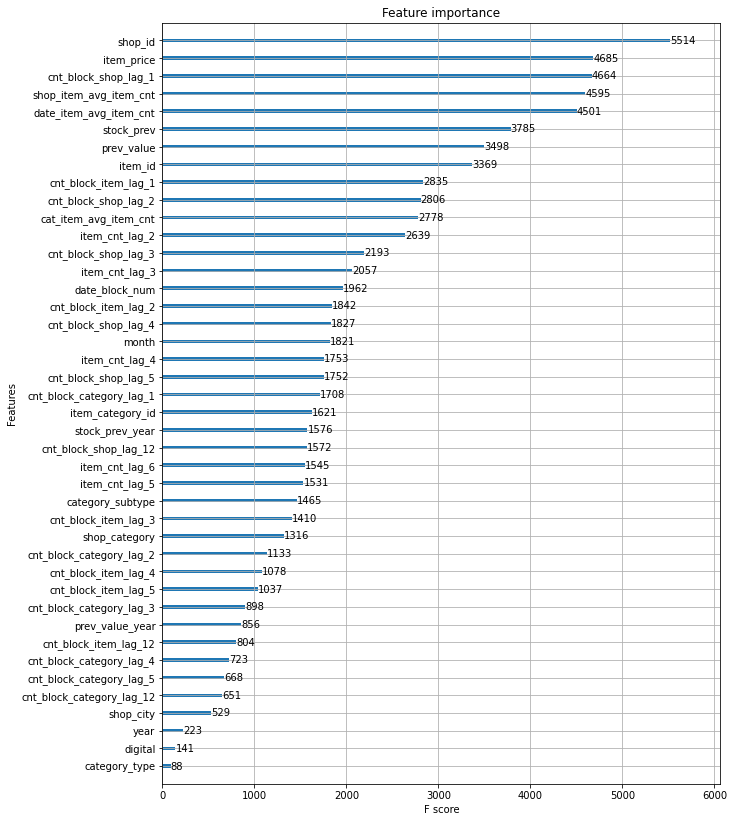

In [34]:
plot_features(xgbr, (10, 14))